# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sean\Anaconda3

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-3, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = {'SGD': keras.optimizers.SGD, 
             'Adagrad': keras.optimizers.Adagrad,  
             'RMSprop': keras.optimizers.RMSprop, 
             'Adam': keras.optimizers.Adam}

In [8]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opt_name, optimizer in OPTIMIZER.items():
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f" % (lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer(lr=lr))

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "opt-%s-lr-%.6f" % (opt_name, lr)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with LR = 0.001000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.2555 - accuracy: 0.1626 - val_loss: 2.1892 - val_accuracy: 0.2122
Epoch 2/50
50000/500

Epoch 50/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6997 - accuracy: 0.4111 - val_loss: 1.7079 - val_accuracy: 0.4049
Experiment with LR = 0.000010
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50

Epoch 49/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.2108 - accuracy: 0.2042 - val_loss: 2.2117 - val_accuracy: 0.2081
Epoch 50/50
50000/50000 [==============================] - 4s 76us/step - loss: 2.2094 - accuracy: 0.2050 - val_loss: 2.2103 - val_accuracy: 0.2096
Experiment with LR = 0.001000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainab

Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3413 - accuracy: 0.5374 - val_loss: 1.4271 - val_accuracy: 0.5008
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.3387 - accuracy: 0.5381 - val_loss: 1.4287 - val_accuracy: 0.4981
Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.3352 - accuracy: 0.5392 - val_loss: 1.4237 - val_accuracy: 0.5006
Experiment with LR = 0.000010
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_______________________________________________

Epoch 47/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9818 - accuracy: 0.3092 - val_loss: 1.9885 - val_accuracy: 0.3026
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.9804 - accuracy: 0.3095 - val_loss: 1.9871 - val_accuracy: 0.3035
Epoch 49/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9789 - accuracy: 0.3103 - val_loss: 1.9857 - val_accuracy: 0.3050
Epoch 50/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.9776 - accuracy: 0.3114 - val_loss: 1.9844 - val_accuracy: 0.3049
Experiment with LR = 0.001000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________________________

Epoch 46/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9621 - accuracy: 0.6594 - val_loss: 1.4301 - val_accuracy: 0.5195
Epoch 47/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9586 - accuracy: 0.6591 - val_loss: 1.4777 - val_accuracy: 0.5162
Epoch 48/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.9478 - accuracy: 0.6622 - val_loss: 1.4238 - val_accuracy: 0.5255
Epoch 49/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.9360 - accuracy: 0.6676 - val_loss: 1.4261 - val_accuracy: 0.5293
Epoch 50/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.9226 - accuracy: 0.6733 - val_loss: 1.4704 - val_accuracy: 0.5182
Experiment with LR = 0.000010
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_______________

Epoch 45/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.4340 - accuracy: 0.5061 - val_loss: 1.4861 - val_accuracy: 0.4819
Epoch 46/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.4293 - accuracy: 0.5086 - val_loss: 1.4800 - val_accuracy: 0.4804
Epoch 47/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.4252 - accuracy: 0.5096 - val_loss: 1.4833 - val_accuracy: 0.4827
Epoch 48/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.4211 - accuracy: 0.5102 - val_loss: 1.4767 - val_accuracy: 0.4832
Epoch 49/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.4176 - accuracy: 0.5121 - val_loss: 1.4748 - val_accuracy: 0.4826
Epoch 50/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.4129 - accuracy: 0.5131 - val_loss: 1.4693 - val_accuracy: 0.4861
Experiment with LR = 0.001000
Model: "model_1"
_________________________________________________________________

Epoch 44/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0515 - accuracy: 0.6247 - val_loss: 1.7189 - val_accuracy: 0.4630
Epoch 45/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0398 - accuracy: 0.6334 - val_loss: 1.6279 - val_accuracy: 0.4719
Epoch 46/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0349 - accuracy: 0.6318 - val_loss: 1.6248 - val_accuracy: 0.4774
Epoch 47/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.0258 - accuracy: 0.6366 - val_loss: 1.5853 - val_accuracy: 0.4902
Epoch 48/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0183 - accuracy: 0.6383 - val_loss: 1.5972 - val_accuracy: 0.5018
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0072 - accuracy: 0.6395 - val_loss: 1.6197 - val_accuracy: 0.4855
Epoch 50/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0001 - accuracy: 0.6467 - val_

Epoch 43/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4665 - accuracy: 0.4953 - val_loss: 1.5132 - val_accuracy: 0.4702
Epoch 44/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4631 - accuracy: 0.4968 - val_loss: 1.5083 - val_accuracy: 0.4764
Epoch 45/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4594 - accuracy: 0.4990 - val_loss: 1.5019 - val_accuracy: 0.4767
Epoch 46/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4542 - accuracy: 0.4996 - val_loss: 1.5090 - val_accuracy: 0.4707
Epoch 47/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4506 - accuracy: 0.4999 - val_loss: 1.5027 - val_accuracy: 0.4773
Epoch 48/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4460 - accuracy: 0.5024 - val_loss: 1.4965 - val_accuracy: 0.4784
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4423 - accuracy: 0.5042 - val_

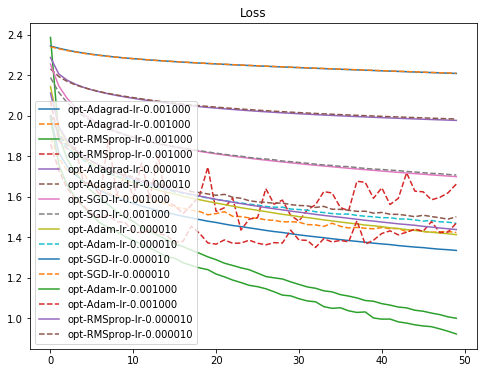

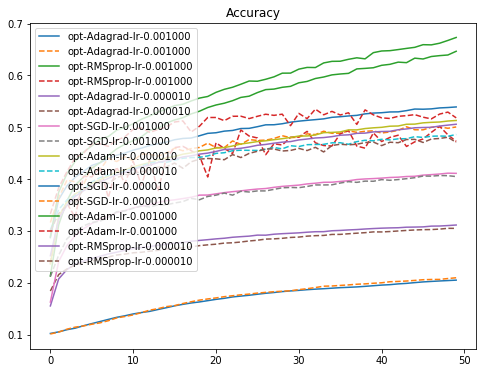

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()